In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from nilearn.plotting import plot_stat_map, view_img
from nilearn.reporting import get_clusters_table
import glob
import os
import numpy as np
import pandas as pd

/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
from fmri_nb_helpers import get_img_path, get_filt_tval_img, plot_filt_tval_img, get_filt_diff_tval_img, plot_filt_diff_tval_img, get_mean_cor_df

# Regressor types

- ev = event; amplitude = 1  
- par = parametric; amplitude = demeaned    
- st = stick (0 duration); amplitude = 1 
- rt = reaction time; amplitude = demeaned RT

Citing Grinband et al. (2008) people agree that reaction times must be taken into account but model them in different ways. Schonberg, Poldrack et al. papers use overall response time for event and parametric regressor as well as a parametric RT regressor. Many in the rest of the decision making literature use boxcars with RT durations (e.g. Dunsmoor et al. (2011), Chang et al. (2011), Chang and Sanfey (2013), Shuck et al. (2016)). 

Since it is common to use boxcars with RT duration and I don't know others who model RT the way Poldrack et al. do I will present those results below.

## Task structure

![alt text](TaskStructure.png)

- Value regressors have the onset and duration of the stimulus presentation period
- Reward and rpe regressors have the onset and duration of the reward presentation screen
- If a regressor is marked 'early' or 'late' its duration is either the first or the last second of the period it is normally modeled in

# Building block models

## Model 1: fractalProb_ev + stim_ev + choiceShift_st + reward_ev

Correlation between regressors averaged across subjects and runs

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "1")

In [ ]:
regs = ['fractalProb_ev', 'stim_ev', 'reward_ev']
mnum = '1'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

Check for left motor cortex activity. Cross is the precentral gyrus peak reported in Hare et al.

In [ ]:
reg = 'choiceShift_st'
mnum = '1'
cut_coords = (-45, -34, 64)
draw_cross = True

plot_filt_tval_img(reg, mnum = mnum, cut_coords = cut_coords, draw_cross = draw_cross)

Motor cortex activity is a little ventral than expected but more consistent for choiceShift regressor. It is, however, not lateralized to the left.

## Model 1a: fractalProb_ev + stim_ev + choiceShiftLeft_st + choiceShiftRight_st + reward_ev

In [ ]:
plot_filt_diff_tval_img(reg="choiceShiftLeft_st", reg_rt1="0", reg_rt2="0", mnum1="1a", mnum2="1", reg2 = "choiceShift_st", cut_coords = cut_coords)
plot_filt_diff_tval_img(reg="choiceShiftRight_st", reg_rt1="0", reg_rt2="0", mnum1="1a", mnum2="1", reg2 = "choiceShift_st", cut_coords = cut_coords)
plot_filt_diff_tval_img(reg="choiceShiftRight_st", reg_rt1="0", reg_rt2="0", mnum1="1a", mnum2="1a", reg2 = "choiceShiftLeft_st", cut_coords = cut_coords)


## Model 2: Model 1 + fractalProb_par

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "2")

In [ ]:
regs = ['fractalProb_ev', 'stim_ev', 'choiceShift_st', 'reward_ev']
mnum = '2'

for reg in regs:
#     plot_filt_diff_tval_img(reg, mnum1="1", mnum2=mnum)
    print('No interesting change from Model 1 for %s in Model %s'%(reg, mnum))

In [ ]:
reg = 'fractalProb_par'
mnum = '2'
plot_filt_tval_img(reg, mnum = mnum)

# Model 3: Model 2 + valBundleSum_par + valChosenMinusUnchosen_par + reward_ev + reward_par + rpeLeftRightSum_par

In [21]:
get_mean_cor_df(reg_rt = "0", mnum = "3", regs = ['fractalProb_par', 'valBundleSum_par', 'valChosenMinusUnchosen_par', 'reward_par', 'rpeLeftRightSum_par'])

,Unnamed: 0,fractalProb_par,valBundleSum_par,valChosenMinusUnchosen_par,reward_par,rpeLeftRightSum_par
2,fractalProb_par,1.000000,-0.091609,-0.119587,-0.013040,-0.002867
4,reward_par,-0.013040,0.065680,0.068950,1.000000,-0.021951
5,rpeLeftRightSum_par,-0.002867,0.039107,0.005916,-0.021951,1.000000
7,valBundleSum_par,-0.091609,1.000000,-0.018201,0.065680,0.039107
8,valChosenMinusUnchosen_par,-0.119587,-0.018201,1.000000,0.068950,0.005916


## Event regressors

In [ ]:
regs = ['fractalProb_ev', 'stim_ev', 'choiceShift_st', 'reward_ev']
mnum = '3'

for reg in regs:
    if reg == 'choiceShift_st':
        plot_filt_tval_img(reg, mnum = mnum, draw_cross=True, cut_coords = (-45, -34, 64))
    else:
        plot_filt_tval_img(reg, mnum = mnum)

## Parametric regressors

Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for valChosenMinusUnchosen_par, model = 3, tstat = 1, reg_rt = 0 at threshold p < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for rpeLeftRightSum_par, model = 3, tstat = 1, reg_rt = 0 at threshold p < 0.05


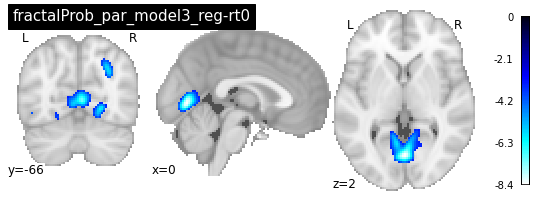

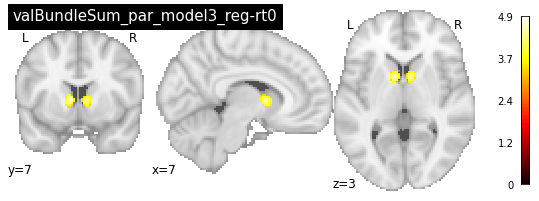

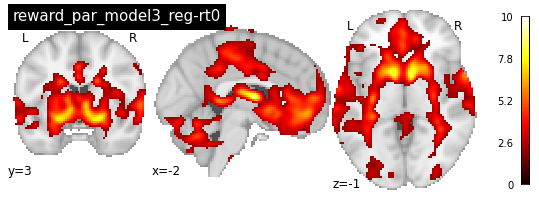

In [22]:
regs = ['fractalProb_par', 'valBundleSum_par', 'valChosenMinusUnchosen_par', 'reward_par', 'rpeLeftRightSum_par']
mnum = '3'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

# Failed attempts at decreasing variance captured by reward_par 

## Model 4: Model 2 + valBundleSum_par + valChosenMinusUnchosenLate_par + reward_ev + reward_par + rpeLeftRightSumEarly_par

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "4", regs = ['fractalProb_par', 'valBundleSum_par', 'valChosenMinusUnchosenLate_par', 'reward_par', 'rpeLeftRightSumEarly_par'])

In [ ]:
regs = ['fractalProb_par','valBundleSum_par', 'valChosenMinusUnchosenLate_par', 'reward_par', 'rpeLeftRightSumEarly_par']
mnum = '4'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

In [ ]:
plot_filt_tval_img("valChosenMinusUnchosenLate_par", mnum = "4", nofilt=True, t_threshold=2.3, cut_coords=(-52, -48, 48))
plot_filt_tval_img("valChosenMinusUnchosenLate_par", mnum = "4", nofilt=True, t_threshold=2.3, cut_coords=(24, 12, 6))
plot_filt_tval_img("rpeLeftRightSumEarly_par", mnum = "4", nofilt=True, t_threshold=2.3, cut_coords=(2, 34, 12))

## Model 5: Model 2 + valBundleSum_par + valChosenMinusUnchosenLate_par + reward_ev + reward_par + rpeLeftRightSumLate_par

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "5", regs = ['fractalProb_par', 'valBundleSum_par', 'valChosenMinusUnchosenLate_par', 'reward_par', 'rpeLeftRightSumLate_par'])

In [ ]:
regs = ['fractalProb_par','valBundleSum_par', 'valChosenMinusUnchosenLate_par', 'reward_par', 'rpeLeftRightSumLate_par']
mnum = '5'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

In [ ]:
plot_filt_tval_img("valChosenMinusUnchosenLate_par", mnum = "5", nofilt=True, t_threshold=2.3, cut_coords=(-52, -48, 48))
plot_filt_tval_img("valChosenMinusUnchosenLate_par", mnum = "5", nofilt=True, t_threshold=2.3, cut_coords=(24, 12, 6))
plot_filt_tval_img("rpeLeftRightSumLate_par", mnum = "5", nofilt=True, t_threshold=2.3, cut_coords=(4, -38, -2))

## Model 6: what happens to rpe without reward_par - nothing. Still doesn't survive.

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "6", regs = ['fractalProb_par', 'valBundleSum_par', 'valChosenMinusUnchosen_par', 'rpeLeftRightSum_par'])

In [ ]:
regs = ['fractalProb_par','valBundleSum_par', 'valChosenMinusUnchosen_par', 'rpeLeftRightSum_par']
mnum = '6'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

In [ ]:
plot_filt_tval_img("valChosenMinusUnchosen_par", mnum = "6", nofilt=True, t_threshold=2.3)
plot_filt_tval_img("rpeLeftRightSum_par", mnum = "6", nofilt=True, t_threshold=2.3, cut_coords =(2, 32, -2))

## Model 7: Does anything for rpe survive with only one fractal included? No.

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "7", regs = ['fractalProb_par', 'valBundleSum_par', 'valChosenMinusUnchosen_par', 'reward_par', 'rpeLeftFractal_par'])

In [ ]:
regs = ['fractalProb_par','valBundleSum_par', 'valChosenMinusUnchosen_par', 'reward_par', 'rpeLeftFractal_par']
mnum = '7'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

In [ ]:
plot_filt_tval_img("rpeLeftFractal_par", mnum = "7", nofilt=True, t_threshold=3, cut_coords=(2, 28, 12))

# Expanding reward screen modeling

- Reward screen - RPE and parametric reward regressor
    - Rewarded vs not rewarded contrast
    - Same RPE regressor for all subjects using average parameter estimates? Very old school and probably wouldn't power the RPE regressor massively.
    - What is on the screen? What might be processed?
        - Left and fractal reward. Whether a fractal is rewarded matters only to the degree it updates beliefs but since these two regressors would be expected to affect the same are at the same time we combine them into one by summing them `rpeLeftRightSum_par`. Results of `rpeLeftRightSumEarly_par` might point towards an initial processing of these outputs before the total trial reward.
        - Reward attribute (red square)`rewardedAttrFractal_st` and `rewardedAttrLottery_st` + their contrast
        - How surprising the reward attribute is. `rewardedAttrSurprise_par`.If rewardFractal then `1-wpFrac`, if rewardLottery `1-(1-wpFrac)=wpFrac`. Note that this is **not** entirely a learning signal since the output is determined by the design more than the subjects' behavior but it might bias behavior nonetheless.
        - Total reward amount `reward_par`
        - Was there a reward for the trial `rewarded_st` and `notRewarded_st` + their contrast
- Value comparison
    - Does limiting the value sum regressor to the beginning (valBundleSum**Early**_par) make valChosenMinusUnchosenLate_par capture more variance?
    
- If these early/late regressor's have effects then maybe eye-tracking is a good idea for this paradigm.

## Model 8: Expanded reward screen modeling

Note the correlation between `reward_par`, `rewarded_st` and `notRewarded_st`

In [23]:
get_mean_cor_df(reg_rt = "0", mnum = "8", regs = ['fractalProb_par','valBundleSum_par', 'valChosenMinusUnchosen_par', 'reward_par', 'rpeLeftRightSum_par', 'rewardedAttrSurprise_par', 'rewarded_st', 'notRewarded_st'])

,Unnamed: 0,fractalProb_par,valBundleSum_par,valChosenMinusUnchosen_par,reward_par,rpeLeftRightSum_par,rewardedAttrSurprise_par,rewarded_st,notRewarded_st
2,fractalProb_par,1.000000,-0.091609,-0.119587,-0.013040,-0.002867,0.022245,-0.008796,0.014154
3,notRewarded_st,0.014154,-0.043996,-0.068729,-0.638223,0.017658,0.020425,-0.341935,1.000000
5,reward_par,-0.013040,0.065680,0.068950,1.000000,-0.021951,-0.028461,0.613609,-0.638223
8,rewardedAttrSurprise_par,0.022245,-0.022482,-0.059808,-0.028461,-0.014241,1.000000,-0.018515,0.020425
9,rewarded_st,-0.008796,0.039643,0.031422,0.613609,-0.018288,-0.018515,1.000000,-0.341935
10,rpeLeftRightSum_par,-0.002867,0.039107,0.005916,-0.021951,1.000000,-0.014241,-0.018288,0.017658
12,valBundleSum_par,-0.091609,1.000000,-0.018201,0.065680,0.039107,-0.022482,0.039643,-0.043996
13,valChosenMinusUnchosen_par,-0.119587,-0.018201,1.000000,0.068950,0.005916,-0.059808,0.031422,-0.068729


Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for valChosenMinusUnchosen_par, model = 8, tstat = 1, reg_rt = 0 at threshold p < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for rpeLeftRightSum_par, model = 8, tstat = 1, reg_rt = 0 at threshold p < 0.05
Nothing survives correction for rewardedAttrFractalVsLottery, model = 8, tstat = 1, reg_rt = 0 at threshold p < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05


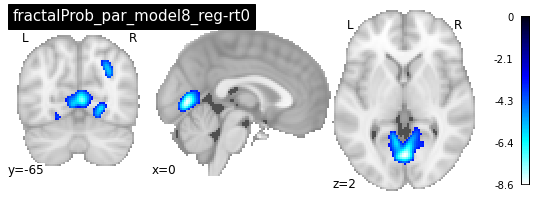

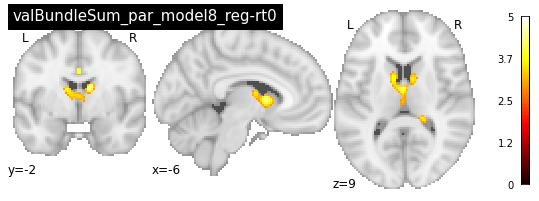

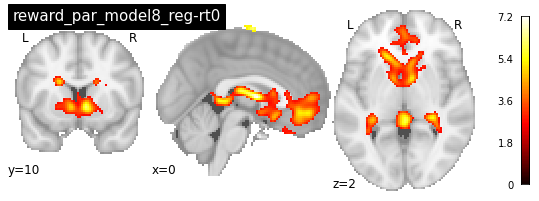

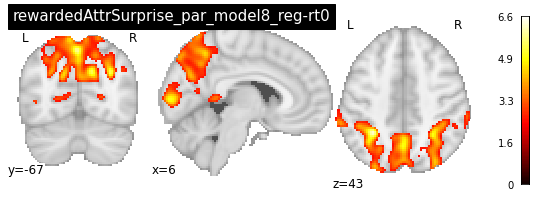

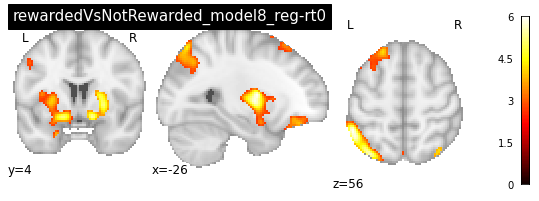

In [33]:
regs = ['fractalProb_par','valBundleSum_par', 'valChosenMinusUnchosen_par', 'reward_par', 'rpeLeftRightSum_par', 
         'rewardedAttrFractalVsLottery', 'rewardedAttrSurprise_par', 'rewardedVsNotRewarded']
mnum = '8'
for reg in regs:
    if reg == 'rewardedVsNotRewarded':
        plot_filt_tval_img(reg, mnum = mnum, cut_coords = (-26, 4, 56))
    else:
        plot_filt_tval_img(reg, mnum = mnum)

Note: though the rewarded vs not rewarded comparison looks sensible the rewarded trial map itself is more confusing with primarily negative coefficients.

Plotting tvalues filtered for corrected p values < 0.05


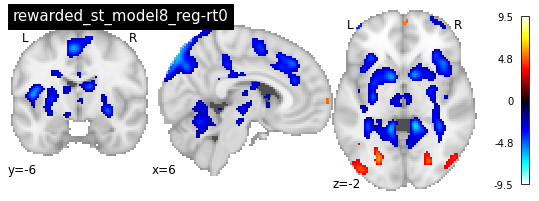

In [37]:
plot_filt_tval_img('rewarded_st', mnum = '8', cut_coords = (6, -6, -2))

Based on the maps above:

- Remore reward attribute (red square)`rewardedAttrFractal_st` and `rewardedAttrLottery_st` + their contrast. Nothing survives for them.
- What to do about value comparison and rpe?
    - Timing: `valBundleSumEarly_par`, `valChosenMinusUnchosenLate_par`, `rpeLeftRightSumEarly_par`

## Model 9: Expanded reward screen modeling with shifted value and rpe regressors 

Shifting the value sum regressors makes it less powerfull and nothing survives for the rpe sum when looking at the first second of the reward screen either.

In [26]:
get_mean_cor_df(reg_rt = "0", mnum = "9", regs = ['fractalProb_par','valBundleSumEarly_par', 'valChosenMinusUnchosenLate_par', 'reward_par', 'rpeLeftRightSumEarly_par', 'rewardedAttrSurprise_par', 'rewarded_st', 'notRewarded_st'])

,Unnamed: 0,fractalProb_par,valBundleSumEarly_par,valChosenMinusUnchosenLate_par,reward_par,rpeLeftRightSumEarly_par,rewardedAttrSurprise_par,rewarded_st,notRewarded_st
2,fractalProb_par,1.000000,-0.104414,-0.124885,-0.013040,-0.004025,0.022245,-0.008796,0.014154
3,notRewarded_st,0.014154,-0.052876,-0.057082,-0.638223,0.020936,0.020425,-0.341935,1.000000
5,reward_par,-0.013040,0.077402,0.078263,1.000000,-0.024350,-0.028461,0.613609,-0.638223
6,rewardedAttrSurprise_par,0.022245,-0.017506,-0.066622,-0.028461,-0.013528,1.000000,-0.018515,0.020425
7,rewarded_st,-0.008796,0.053829,0.055246,0.613609,-0.021465,-0.018515,1.000000,-0.341935
8,rpeLeftRightSumEarly_par,-0.004025,0.043822,-0.002244,-0.024350,1.000000,-0.013528,-0.021465,0.020936
10,valBundleSumEarly_par,-0.104414,1.000000,-0.014896,0.077402,0.043822,-0.017506,0.053829,-0.052876
11,valChosenMinusUnchosenLate_par,-0.124885,-0.014896,1.000000,0.078263,-0.002244,-0.066622,0.055246,-0.057082


Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for valChosenMinusUnchosenLate_par, model = 9, tstat = 1, reg_rt = 0 at threshold p < 0.05
Nothing survives correction for rpeLeftRightSumEarly_par, model = 9, tstat = 1, reg_rt = 0 at threshold p < 0.05


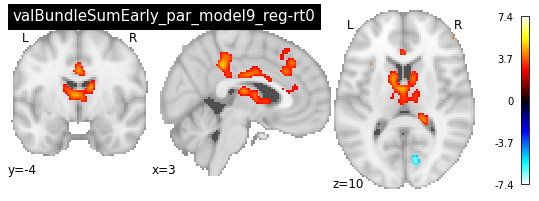

In [5]:
# regs = ['fractalProb_par','valBundleSumEarly_par', 'valChosenMinusUnchosenLate_par', 'reward_par', 'rpeLeftRightSumEarly_par', 
#         'rewardedAttrSurprise_par', 'rewardedVsNotRewarded']
regs = ['valBundleSumEarly_par', 'valChosenMinusUnchosenLate_par', 'rpeLeftRightSumEarly_par']
mnum = '9'
for reg in regs:
    if reg == 'rewardedVsNotRewarded':
        plot_filt_tval_img(reg, mnum = mnum, cut_coords = (-26, 4, 56))
    else:
        plot_filt_tval_img(reg, mnum = mnum)

## Model 10: Relative value and rpe regressors

Relative value is a lot more scattered and relative rpe still doesn't survive.

In [28]:
get_mean_cor_df(reg_rt = "0", mnum = "10", regs = ['fractalProb_par', 'valRelativeLeftBundle_par', 'reward_par', 'rpeRelativeLeftFractal_par', 'rewardedAttrSurprise_par', 'rewarded_st', 'notRewarded_st'])

,Unnamed: 0,fractalProb_par,valRelativeLeftBundle_par,reward_par,rpeRelativeLeftFractal_par,rewardedAttrSurprise_par,rewarded_st,notRewarded_st
2,fractalProb_par,1.000000,-0.029480,-0.013040,0.000205,0.022245,-0.008796,0.014154
3,notRewarded_st,0.014154,-0.036266,-0.638223,0.000751,0.020425,-0.341935,1.000000
5,reward_par,-0.013040,0.061535,1.000000,-0.000168,-0.028461,0.613609,-0.638223
6,rewardedAttrSurprise_par,0.022245,-0.017729,-0.028461,0.000023,1.000000,-0.018515,0.020425
7,rewarded_st,-0.008796,0.035509,0.613609,-0.000994,-0.018515,1.000000,-0.341935
8,rpeRelativeLeftFractal_par,0.000205,0.002353,-0.000168,1.000000,0.000023,-0.000994,0.000751
10,valRelativeLeftBundle_par,-0.029480,1.000000,0.061535,0.002353,-0.017729,0.035509,-0.036266


Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for rpeRelativeLeftFractal_par, model = 10, tstat = 1, reg_rt = 0 at threshold p < 0.05


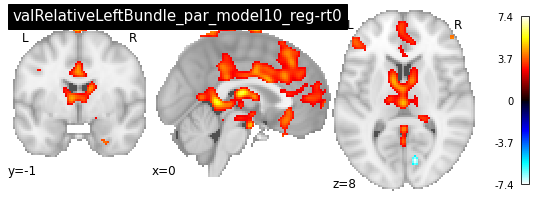

In [6]:
# regs = ['fractalProb_par','valRelativeLeftBundle_par', 'reward_par', 'rpeRelativeLeftFractal_par', 'rewardedAttrSurprise_par', 'rewardedVsNotRewarded']
regs = ['valRelativeLeftBundle_par', 'rpeRelativeLeftFractal_par']
mnum = '10'
for reg in regs:
    if reg == 'rewardedVsNotRewarded':
        plot_filt_tval_img(reg, mnum = mnum, cut_coords = (-26, 4, 56))
    else:
        plot_filt_tval_img(reg, mnum = mnum)

# Where is the "learning" signal?

The expanded modeling of the reward screen reduced some of the variance associated with the `reward_par` regressor by loading some onto the `rewardedAttrSurprise_par` regressor and the `rewardedVsNotRewarded` contrast.

It did not, however, result in anything surviving for `rpeLeftRightSum_par` (model 8), `rpeLeftRightSumEarly_par` (model 9) or `rpeRelativeLeftFractal` (model 10).

Behavioral analyses show, however, that subjects are more likely to choose the bundle with the better fractal later in the task suggesting that subjects **learn** fractal values.

We also know, that behavior depends more on the fractal value difference the more **relevant** the fractals are

When would learning happen? During the reward screen. But there is a lot of information to process on this screen so maybe learning is not as consistent as the current behavioral model would suggest but context-dependant.

Model where continously updated rpe's expression is weighted by its relevance for the trial's reward:
- Does how much you learn depend on how relevant the fractals were for that trial? `rpeWeightedByRelevance_par = rpeLeftRightSum_par` * `fractalProb_par` (model11a) Or by perceived relevance? `rpeWeightedByPerceivedRelevance_par = rpeLeftRightSum_par * wpFrac` (model11b)

Models that imply rpe's that are **not** updated after each trial. For these I should first fit the behavioral model and do a model comparison with the model that updates the rpe after each trial.
- Do you only learn about the fractals when they are the rewarded attribute? `rpeWhenFractalRewarded_par = np.where(fractalDraw, rpeLeftRightSum_par, 0)` 
- Do you only learn about the fractal in the chosen bundle? `rpeChosenBundleFractal_par = np.where(choiceLeft, rpeLeft, rpeRight)` 

## Model 11a: rpe weighted by pFractal

rpe still doesn't survive but value also becomes a lot weaker

In [8]:
get_mean_cor_df(reg_rt = "0", mnum = "11a", regs = ['fractalProb_par','valBundleSum_par', 'reward_par', 'rpeWeightedByRelevance_par', 'rewardedAttrSurprise_par', 'rewarded_st', 'notRewarded_st'])

,Unnamed: 0,fractalProb_par,valBundleSum_par,reward_par,rpeWeightedByRelevance_par,rewardedAttrSurprise_par,rewarded_st,notRewarded_st
2,fractalProb_par,1.000000,-0.091609,-0.013040,-0.000508,0.022245,-0.008796,0.014154
3,notRewarded_st,0.014154,-0.043996,-0.638223,-0.001020,0.020425,-0.341935,1.000000
5,reward_par,-0.013040,0.065680,1.000000,-0.001418,-0.028461,0.613609,-0.638223
6,rewardedAttrSurprise_par,0.022245,-0.022482,-0.028461,-0.000655,1.000000,-0.018515,0.020425
7,rewarded_st,-0.008796,0.039643,0.613609,0.000603,-0.018515,1.000000,-0.341935
8,rpeWeightedByRelevance_par,-0.000508,0.000587,-0.001418,1.000000,-0.000655,0.000603,-0.001020
10,valBundleSum_par,-0.091609,1.000000,0.065680,0.000587,-0.022482,0.039643,-0.043996


Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for rpeWeightedByRelevance_par, model = 11a, tstat = 1, reg_rt = 0 at threshold p < 0.05


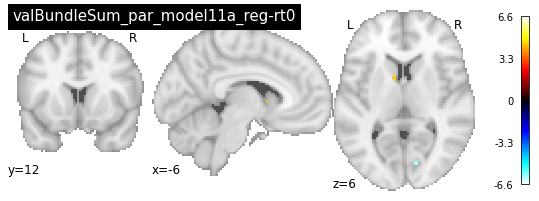

In [9]:
# regs = ['fractalProb_par','valBundleSum_par', 'reward_par', 'rpeWeightedByRelevance_par', 'rewardedAttrSurprise_par', 'rewardedVsNotRewarded']
regs = ['valBundleSum_par', 'rpeWeightedByRelevance_par']
mnum = '11a'
for reg in regs:
    if reg == 'rewardedVsNotRewarded':
        plot_filt_tval_img(reg, mnum = mnum, cut_coords = (-26, 4, 56))
    elif reg == 'valBundleSum_par':
        plot_filt_tval_img(reg, mnum=mnum, cut_coords = (-6, 12, 6))
    else:
        plot_filt_tval_img(reg, mnum = mnum)

## Model 11b: rpe weighted by wpFractal

rpe still doesn't survive but value also becomes a lot weaker

In [12]:
get_mean_cor_df(reg_rt = "0", mnum = "11b", regs = ['fractalProb_par','valBundleSum_par', 'reward_par', 'rpeWeightedByPerceivedRelevance_par', 'rewardedAttrSurprise_par', 'rewarded_st', 'notRewarded_st'])

,Unnamed: 0,fractalProb_par,valBundleSum_par,reward_par,rpeWeightedByPerceivedRelevance_par,rewardedAttrSurprise_par,rewarded_st,notRewarded_st
2,fractalProb_par,1.000000,-0.091609,-0.013040,-0.000229,0.022245,-0.008796,0.014154
3,notRewarded_st,0.014154,-0.043996,-0.638223,-0.001231,0.020425,-0.341935,1.000000
5,reward_par,-0.013040,0.065680,1.000000,-0.001448,-0.028461,0.613609,-0.638223
6,rewardedAttrSurprise_par,0.022245,-0.022482,-0.028461,-0.001188,1.000000,-0.018515,0.020425
7,rewarded_st,-0.008796,0.039643,0.613609,0.000824,-0.018515,1.000000,-0.341935
8,rpeWeightedByPerceivedRelevance_par,-0.000229,0.000071,-0.001448,1.000000,-0.001188,0.000824,-0.001231
10,valBundleSum_par,-0.091609,1.000000,0.065680,0.000071,-0.022482,0.039643,-0.043996


Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for rpeWeightedByPerceivedRelevance_par, model = 11b, tstat = 1, reg_rt = 0 at threshold p < 0.05


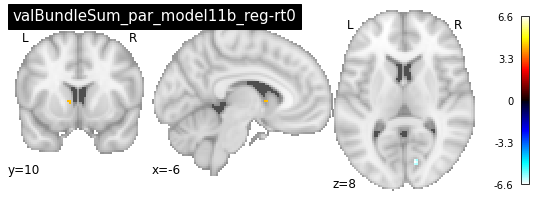

In [14]:
# regs = ['fractalProb_par','valBundleSum_par', 'reward_par', 'rpeWeightedByPerceivedRelevance_par', 'rewardedAttrSurprise_par', 'rewardedVsNotRewarded']
regs = ['valBundleSum_par', 'rpeWeightedByPerceivedRelevance_par']
mnum = '11b'
for reg in regs:
    if reg == 'rewardedVsNotRewarded':
        plot_filt_tval_img(reg, mnum = mnum, cut_coords = (-26, 4, 56))
    elif reg == 'valBundleSum_par':
        plot_filt_tval_img(reg, mnum=mnum, cut_coords = (-6, 10, 8))
    else:
        plot_filt_tval_img(reg, mnum = mnum)

## Model 12: RPE from best fitting behavioral model

In [31]:
get_mean_cor_df(reg_rt = "0", mnum = "12", regs = ['fractalProb_par','valBundleSum_par', 'reward_par', 'rpeBestModelLeftRightSum_par', 'rewardedAttrSurprise_par', 'rewarded_st', 'notRewarded_st'])

,Unnamed: 0,fractalProb_par,valBundleSum_par,reward_par,rpeBestModelLeftRightSum_par,rewardedAttrSurprise_par,rewarded_st,notRewarded_st
2,fractalProb_par,1.000000,-0.106854,-0.013040,0.017156,0.030293,-0.008796,0.014154
3,notRewarded_st,0.014154,-0.050106,-0.638223,0.008682,0.021437,-0.341935,1.000000
5,reward_par,-0.013040,0.068991,1.000000,-0.012885,-0.031258,0.613609,-0.638223
6,rewardedAttrSurprise_par,0.030293,-0.018261,-0.031258,-0.018124,1.000000,-0.019792,0.021437
7,rewarded_st,-0.008796,0.042252,0.613609,-0.008767,-0.019792,1.000000,-0.341935
8,rpeBestModelLeftRightSum_par,0.017156,0.025842,-0.012885,1.000000,-0.018124,-0.008767,0.008682
10,valBundleSum_par,-0.106854,1.000000,0.068991,0.025842,-0.018261,0.042252,-0.050106


Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for rpeBestModelLeftRightSum_par, model = 12, tstat = 1, reg_rt = 0 at threshold p < 0.05


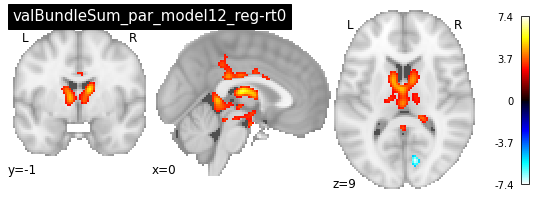

In [15]:
# regs = ['fractalProb_par','valBundleSum_par', 'reward_par', 'rpeBestModelLeftRightSum_par', 'rewardedAttrSurprise_par', 'rewardedVsNotRewarded']
regs = ['valBundleSum_par', 'rpeBestModelLeftRightSum_par']
mnum = '12'
for reg in regs:
    if reg == 'rewardedVsNotRewarded':
        plot_filt_tval_img(reg, mnum = mnum, cut_coords = (-26, 4, 56))
    else:
        plot_filt_tval_img(reg, mnum = mnum)

# RPE never survives but how do other things change?

## Reward across models

After adding `rewardedAttrSurprise_par`, `rewarded_st` and `notRewarded_st` to modeling the reward screen all other changes done to the rpe regressor has primarily affected the value map and not the reward map.

Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05


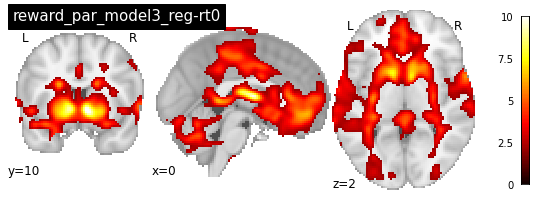

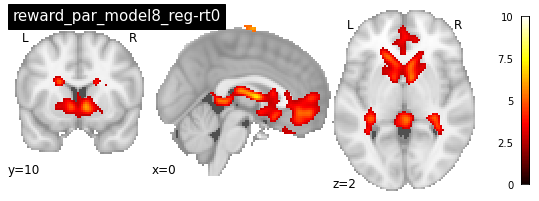

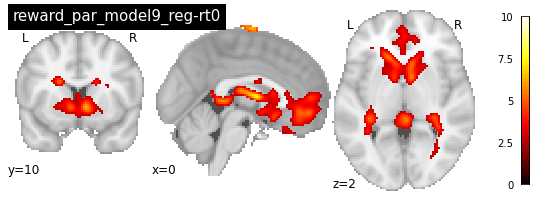

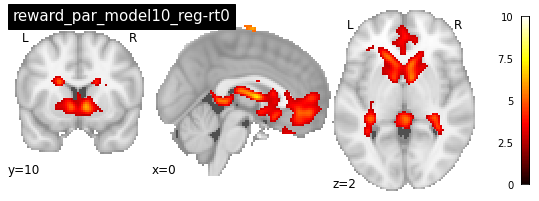

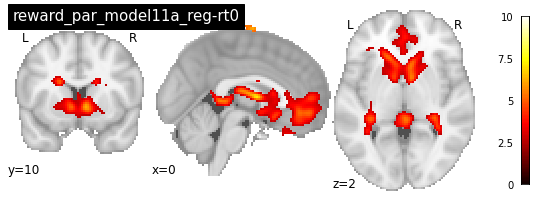

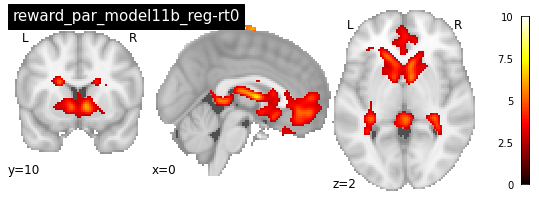

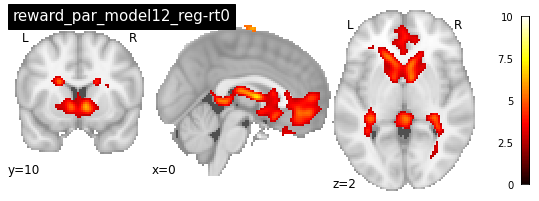

In [4]:
models = ['3', '8', '9', '10', '11a', '11b', '12']

for m in models:
    plot_filt_tval_img('reward_par', mnum = m, vmax = 10, cut_coords=(0, 10, 2))

## Value across models

Visualizing value regressors on the same scale at the same slice.

- Model 3: Modeling the reward screen only with `reward_par` and `rpeLeftRightSum_par` results in very localized value
- Model 8: Initial expansion of reward screen modeling by adding `rewardedAttrSurprise_par`, `rewarded_st` and `notRewarded_st` increases and spreads value activation.
- Model 9: Modeling the value sum only in the first second of the stimulus presentation captures variance in the cingulate and dmpfc as well.
- Model 10: Modeling relative value (left - right) increases this spread further
- Model 11a/b: Multiplying rpe with either objective or subjective prob fractal draw removes almost all value effects.
- Model 12: Using the rpe from the best fitting behavioral model spreads value to cingulate but not dmpfc.

Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05


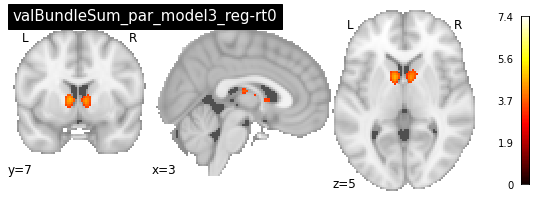

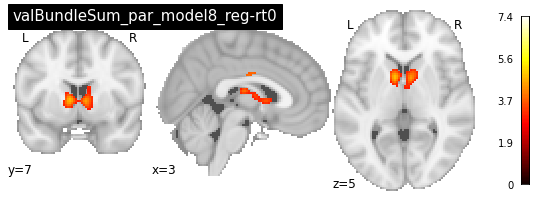

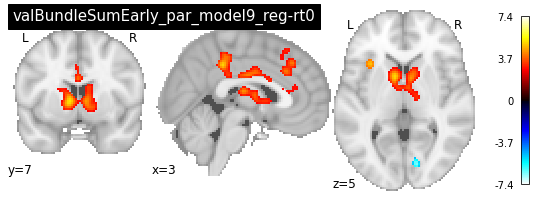

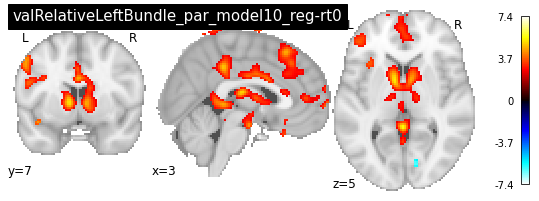

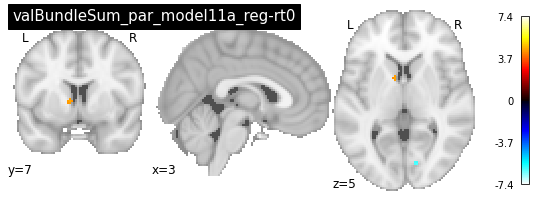

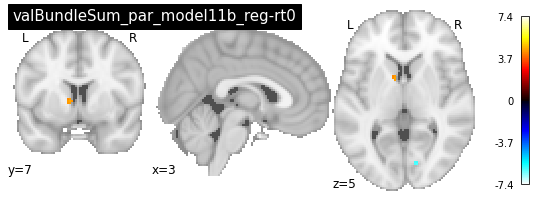

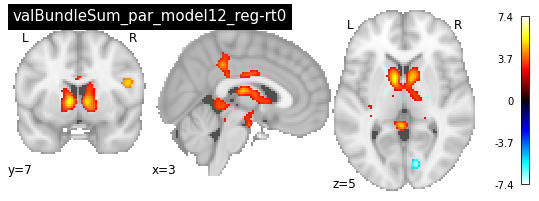

In [3]:
regs_dict = {'3': 'valBundleSum_par', '8': 'valBundleSum_par', '9': 'valBundleSumEarly_par', '10': 'valRelativeLeftBundle_par', '11a': 'valBundleSum_par', '11b': 'valBundleSum_par', '12': 'valBundleSum_par'}

for k, v in regs_dict.items():
    plot_filt_tval_img(v, mnum = k, vmax=7.4, cut_coords = (3, 7, 5))

# Ideas from re-reading the dissertation:

- Two valuation systems; though not clear how descriptive vs experiental relates to model-free vs model-based 
    - Should I review attribute versus option based valuation literature?

- "Relative strength of preference (i.e., to what degree one option was better than the other in each valuation system)". Operationally, `leftEVAdv` and `leftQVAdv`. If the EV adv is a lot more than the QV adv does the decision should depend more on that than the QV? In the dissertation this is operationalized as a "nested model" adding two more parameters to the two value systems model: Curvature of the weight adjustment variabled `B` that modifies the weight for each system (wpFrac) to `u`. The nested model is then fit to data and compared to the nonlinear model compared to which it underperforms and is therefore rejectied.
    - The dissertation talks about this as an endogenous change as opposed pFrac/wpFrac, which are exogenous. I don't agree with that distinction and it seems they should interact such that the effect of the relative strength of preference should be more notable when pFrac/wpFrac isn't very large or small.
    - Could this still affect the value, reward or learning signal representations?

- Allocation of "control" based on "uncertainty in the estimates from the experiential system", choosing the system with more certain value estimates. Do I currently have an estimate of uncertainty in the QV estimates? The dissertation computes a QV posterior distribution for each trial and use the variance of this distribution. A second measure (inspired by Lee et al. 2014) is the sum of rpe's. Mixed effect models including the weighted absolute value difference for each attribute and their interactions with these uncertainty measures showed that they don't have significant effects on behavior.
    - How might this uncertainty in value estimates be represented in the brain?
    - How about allocation of control based on conflict vs. no conflict trials?

- Separating value of lottery and fractals. Tried this before and only value of lottery seemed to survive. Should I revisit this? 
